In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgbm
import pickle
import optuna

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

c:\Users\user\miniconda3\envs\ds\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Загрузим и объединим обучающую и тестовую выборки для предобработки. У нас нет признаков, которые считаются, задействуя весь датафрейм, поэтому такое объединение не вызовет утечки данных. Но это позволит корректно создать лаговые признаки для тестовой выборки

## Предобработка и feature engineering

In [34]:
train_df = pd.read_csv('train_dataset.csv')
test_df = pd.read_csv('test_dataset.csv')
df = pd.concat([train_df, test_df])[['date', 'time', 'target', 'temp_pred', 'weather_pred', 'temp']]
df['date'] = pd.to_datetime(df['date']).dt.normalize()

#get test dates for future model fitting
start_test = test_df['date'].min()
end_test = test_df['date'].max()

#fix some minor missing values in weather forecasts
df = df.ffill()
print(df.shape)
df.head()

(40152, 6)


,date,time,target,temp_pred,weather_pred,temp
0,2019-01-01,0,481.510,2.0,"пасм, ветер",2.9
1,2019-01-01,1,462.872,2.0,"пасм, ветер",2.9
2,2019-01-01,2,449.718,2.0,"пасм, ветер",2.9
3,2019-01-01,3,430.908,2.0,"пасм, ветер",4.3
4,2019-01-01,4,415.163,2.0,"пасм, ветер",4.3


Добавим в полученный датафрейм отобранные нами признаки. Функции, перечисленные ниже добавляют только те признаки, которые оказались полезными, т.е. улучшали метрику в ходе наших экспериментов

In [3]:
def add_calendar_features(df):
    """
    Функция извлекает из даты и добавляет в датафрейм календарные фичи: день (число), 
    день недели, номер недели, месяц, год
    """
    df['date'] = pd.to_datetime(df['date']).dt.normalize()
    df['dow'] = df['date'].dt.dayofweek
    df['day'] = df['date'].dt.day
    df['week'] = df['date'].dt.isocalendar().week.astype('int32')
    df['month'] = df['date'].dt.month

    #OHE code month
    months = {1: 'jan', 2: 'feb', 3: 'mar', 4: 'apr', 5: 'may', 6: 'jun',
            7: 'jul', 8: 'aug', 9: 'sep', 10: 'oct', 11: 'nov', 12: 'dec'}
    for month in months:
        df[months[month]] = np.where((df['month'] == month), 1, 0)

    return df

In [4]:
def add_lags(df):
    """
    Функция добавляет избранные лаги для целевой переменной и температуры
    """
    #add target lags
    for i in [24, 24*2, 24*3, 24*4, 24*5, 24*6, 24*7, 25, 26, 49]:
        df[f'target_lag_{i}'] = df['target'].shift(i)

    #add yesterdays target and temperature statistics
    for feature in ['target', 'temp']:
        daily = df.groupby('date', as_index=False)[feature].agg(daily_mean='mean', daily_median='median', daily_max='max', daily_min='min')
        for stat in ['mean', 'median', 'max', 'min']:
            daily[f'yesterday_{stat}_{feature}'] = daily[f'daily_{stat}'].shift(1)
        df = df.merge(daily[['date', f'yesterday_mean_{feature}', f'yesterday_median_{feature}', f'yesterday_max_{feature}', f'yesterday_min_{feature}']], how='left', on='date')
        df[f'yesterday_diff_{feature}'] = df[f'yesterday_max_{feature}'] - df[f'yesterday_min_{feature}']

    #add a temperature lag
    for i in range(1,5):
        df[f'temp_lag_{i}'] = df['temp'].shift(24*i)

    #delete nans where there's no lag data (start of period)
    df['na_sum'] = df.isna().sum(axis=1)
    df = df[df['na_sum'] == 0]
    df = df.drop('na_sum', axis=1)

    #drop actual temperature as it causes dataleaks
    df = df.drop('temp', axis=1)

    return df

In [5]:
def add_weather_and_daylight(df):
    """
    Функция обрабатывает данные о природном освещении и погоде, создавая в итоге бинарный 
    признак, помечающий часы, когда должно быть светло, потому что солнце над горизонтом,
    но темно из-за погодных условий. Мы используем прогнозную погоду во избежание утечек
    """
    #create columns for certain bad weather types
    bad_weathers = {'пасм': 'overcast', 'дожд': 'rain', 'снег': 'snow', 
                    'ливень': 'heavy_rain', 'гроз': 'thunder', 'шторм': 'storm'}
    for weather_type in bad_weathers:
        df[bad_weathers[weather_type]] = np.where(df['weather_pred'].str.contains(weather_type), 1, 0)

    #process cloudy separately so that not to include 'малообл' 
    df['cloudy'] = np.where((df['weather_pred'].str.contains(' обл')) |
                            (df['weather_pred'].str.startswith('обл')), 1, 0)
    
    #read and preprocess our table with sunset and sunrise times for each day
    daylight = pd.read_csv('light_day.csv')
    daylight = daylight.rename(columns={'Дата': 'date', 'Восход': 'sunrise', 'Заход': 'sunset'})
    daylight = daylight[['date', 'sunrise', 'sunset']]
    daylight['date'] = pd.to_datetime(daylight['date']).dt.normalize()
    daylight['day'] = daylight['date'].dt.day
    daylight['month'] = daylight['date'].dt.month
    daylight['sunrise'] = daylight['sunrise'].str.replace(':', '.').str.lstrip('0').astype('float')
    daylight['sunset'] = daylight['sunset'].str.replace(':', '.').str.lstrip('0').astype('float')
    daylight = daylight[['day', 'month', 'sunrise', 'sunset']]

    #merge sunset and sunrise data to original df
    df_with_daylight = df.merge(daylight, on=['month', 'day'], how='left')

    #mark light hours, i.e. those between sunrise and sunset
    df_with_daylight['light'] = np.where(df_with_daylight['time'].between(df_with_daylight['sunrise'], 
                                                                    df_with_daylight['sunset']), 1, 0)
    
    #mark hours that should be light but are dark because of bad weather conditions
    df_with_daylight['dark_weather'] = np.where((df_with_daylight['light'] == 1) & 
                                  (df_with_daylight[['rain', 'heavy_rain', 'thunder', 
                                                  'storm', 'snow', 'overcast', 'cloudy']].any(axis='columns') == 1), 1, 0)
    
    #drop interim features that didn't prove useful
    df_with_daylight = df_with_daylight.drop(['weather_pred', 'sunrise', 'sunset', 'cloudy', 'heavy_rain', 
                                              'thunder', 'storm', 'overcast', 'rain', 'snow', 'light'], axis=1)

    return df_with_daylight

In [6]:
def add_daysoff(df):
    """
    Функция загружает файлы производственных календарей, обрабатывает их и проставляет 
    метку 1 для всех выходных и праздничных дней. Эта категория шире суббот и воскресений
    (что мы ранее извлекли из даты), т.к. включает дополнительно государственные праздники
    и нерабочие дни, объявленные указами президента
    Кроме того, функция создает столбец "рабочий час", отмечая единицами часы, являющиеся
    рабочими по производственному календарю с учетом коротких дней перед праздниками
    """
    #read and preprocess tables with Russian production calendars
    c19 = pd.read_csv('calendar2019.csv')
    c20 = pd.read_csv('calendar2020.csv')
    c21 = pd.read_csv('calendar2021.csv')
    c22 = pd.read_csv('calendar2022.csv')
    c23 = pd.read_csv('calendar2023.csv')

    def get_daysoff(df, year):
        """
        Функция принимает датафрейм производственного календаря и возвращает список
        всех выходных дней в соответствующем году
        """
        months = {'Январь': '01', 'Февраль': '02', 'Март': '03', 'Апрель': '04', 'Май': '05', 'Июнь': '06',
        'Июль': '07', 'Август': '08', 'Сентябрь': '09', 'Октябрь': '10', 'Ноябрь': '11', 'Декабрь': '12'}
        
        yearly_daysoff = []
        yearly_short = []
        for month in months:
            #filter out days with *. these are working short days before a holiday
            daysoff = [day for day in df[month].item().split(',') if '*' not in day]            
            daysoff = [day if len(day) > 1 else '0'+day for day in daysoff]

            #make a separate list of short working days (prior to a holiday)
            short_days = [day for day in df[month].item().split(',') if '*' in day]
            short_days = [day if len(day) > 1 else '0'+day for day in short_days]

            #format as proper dates
            daysoff = [(year + '-' + months[month] + '-' + day) for day in daysoff]
            yearly_daysoff.extend(daysoff)
            short_days = [(year + '-' + months[month] + '-' + day) for day in short_days]
            yearly_short.extend(short_days)

        return yearly_daysoff, yearly_short

    #get days off for all 5 years
    all_daysoff = []
    all_short = []
    years = {'2019': c19, '2020': c20, '2021': c21, '2022': c22, '2023': c23}
    for year in years:
        all_daysoff.extend(get_daysoff(df=years[year], year=year)[0])
        all_short.extend(get_daysoff(df=years[year], year=year)[1])

    #add daysoff and short feature to original df
    df['dayoff'] = np.where(df['date'].astype('str').isin(all_daysoff), 1, 0)
    df['working_short'] = np.where(df['date'].astype('str').isin(all_short), 1, 0)

    #mark working hours
    df['working_hour'] = np.where(((df['dayoff'] == 0) & (df['working_short'] == 0) & (df['time'].isin(list(range(9, 18))))) |
                                  ((df['dayoff'] == 0) & (df['working_short'] == 1) & (df['time'].isin(list(range(9, 17))))), 1, 0)
    
    df = df.drop('working_short', axis=1)

    return df    

In [7]:
def add_school_vacations(df):
    """
    Функция отмечает единицами дни школьных каникул и нулями - все остальные дни
    """
    vacs = pd.read_csv('holidays.csv')
    vacs = vacs.rename(columns={'Дата': 'date', 'Каникулы': 'school_vac'})
    vacs['date'] = pd.to_datetime(vacs['date']).dt.normalize()
    df = df.merge(vacs, on='date', how='left')
    return df

Добавим все созданные нами признаки в датафрейм

In [8]:
def add_sin_cos_time(df):
    """
    Функция заменяет оригинальное время (по 24-часовой шкале) его циклической
    категоризацией. Это нужно для того, чтобы расстояние между 23 и 0 часов не было
    больше, чем для любой другой пары соседних часов
    """
    def cos_sin_categorise(data, cos_column_name, sin_column_name, column_to_categorise):
        """
        Применяет cos-sin тригонометрическую категоризацию
        :param data: DataFrame содержащий данные
        :param cos_column_name: Название будущей колонки с cos
        :param sin_column_name: Название будущей колонки с sin
        :param column_to_categorise: Назване колонки, которое хотим категоризовать
        """
        data[cos_column_name] = np.cos((2*np.pi *data[column_to_categorise])/data[column_to_categorise].nunique())
        data[sin_column_name] = np.sin((2*np.pi *data[column_to_categorise])/data[column_to_categorise].nunique())

    cos_sin_categorise(data=df, cos_column_name='cos_time', sin_column_name='sin_time', column_to_categorise='time')
    return df

In [9]:
df = add_calendar_features(df)
df = add_lags(df)
df = add_weather_and_daylight(df)
df = add_daysoff(df)
df = add_sin_cos_time(df)
df = add_school_vacations(df)
print(df.shape)
df.head()

(39984, 50)


,date,time,target,temp_pred,dow,day,week,month,jan,feb,...,temp_lag_1,temp_lag_2,temp_lag_3,temp_lag_4,dark_weather,dayoff,working_hour,cos_time,sin_time,school_vac
0,2019-01-08,0,517.676,-1.0,1,8,2,1,1,0,...,-3.2,-2.0,2.8,-5.7,0,1,0,1.000000,0.000000,1
1,2019-01-08,1,485.831,-1.0,1,8,2,1,1,0,...,-3.2,-2.0,2.8,-5.7,0,1,0,0.965926,0.258819,1
2,2019-01-08,2,461.959,-1.0,1,8,2,1,1,0,...,-3.2,-2.0,2.8,-5.7,0,1,0,0.866025,0.500000,1
3,2019-01-08,3,449.592,-1.0,1,8,2,1,1,0,...,-2.5,-2.8,3.4,-6.9,0,1,0,0.707107,0.707107,1
4,2019-01-08,4,440.941,-1.0,1,8,2,1,1,0,...,-2.5,-2.8,3.4,-6.9,0,1,0,0.500000,0.866025,1


## Первый этап: обучение линейной модели

На первом этапе мы обучаем линейную регрессию с регуляризацией. Мы остановили свой выбор на таком типе алгоритмов машинного обучения, поскольку линейные модели, в отличие от деревянных, хороши в экстраполировании найденных зависимостей. Кроме того, выбранная нами лассо-регрессия - хороший выбор для анализа важности признаков, т.к. используемая ей l1 регуляризация зануляет вес незначимых признаков.

In [10]:
def evaluate(y_true, y_pred, model_name):
    """
    Функция рассчитывает и выводит метрики модели
    :param y_true: вектор истинных значений целевой переменной
    :param y_pred: вектор предсказаний модели
    :model_name: имя модели (для вывода)
    """
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    #print metrics...
    metrics = {'MAE': mae, 'MAPE': mape, 'r2': r2}
    for metric in metrics:
        print(f"{model_name} {metric}: {metrics[metric]}")

    #... and return them
    return mae, mape, r2   

In [11]:
def linear_cross_val(cols_to_take, df=df):
    """
    Функция кросс-валидации для Лассо регрессии
    :param cols_to_take: столбцы, которые модель использует в качестве признаков
    :param df: датафрейм, который необходимо разделить на обучающую и тестовую выборки
    """
    maes = []
    mapes = []
    r2 = []

    #separate test from train and valid. it's always the same and corresponds to test_dataset.csv
    crossval_set = df[df['date'] < test_df['date'].min()]

    #use time series split to split train and valid. valid size is about 6 months (3 for valid and 3 for test)
    tscv = TimeSeriesSplit(test_size=91*24)

    for i, (train_index, test_index) in enumerate(tscv.split(crossval_set)):
        print(f"Fold {i+1}:")
        train = crossval_set[crossval_set.index.isin(train_index)]
        test = crossval_set[crossval_set.index.isin(test_index)]

        end_train = train['date'].max()
        start_test = test['date'].min()
        end_test = test['date'].max()
        test_dates = test['date']

        print(f"End of train: {end_train.date()}")
        print(f"Test: from {start_test.date()} to {end_test.date()}")

        X_train = train[cols_to_take]
        y_train = train['target']         
        X_test = test[cols_to_take]
        y_test = test['target']  

        pipe = make_pipeline(StandardScaler(), Lasso(alpha=0.275))
        pipe.fit(X_train, y_train)
                   
        #predict for test
        preds = pipe.predict(X_test)    
        preds = pd.DataFrame({'y_pred': preds, 'date': test_dates, 'y_true': y_test})  
        
        #evaluete model
        metrics = evaluate(preds['y_true'], preds['y_pred'], 'Lasso')
        maes.append(metrics[0])
        mapes.append(metrics[1])
        r2.append(metrics[2])

        #plot test fact and forecast
        plot_df = pd.DataFrame({'date': preds['date'].head(14*24), 'y_true': preds['y_true'].head(14*24), 'y_pred': preds['y_pred'].head(14*24)})
        fig, ax = plt.subplots(figsize=(12, 3))
        g = sns.lineplot(data=plot_df)
        plt.title(f'CV step {i+1}')
        plt.show()        

    #return model from last fold. it is fit on maximum train dataset
    return(maes, mapes, r2, pipe)

Fold 1:
End of train: 2021-12-31
Test: from 2022-01-01 to 2022-04-01
Lasso MAE: 12.458201731691751
Lasso MAPE: 0.022220273181866847
Lasso r2: 0.9404288312665497


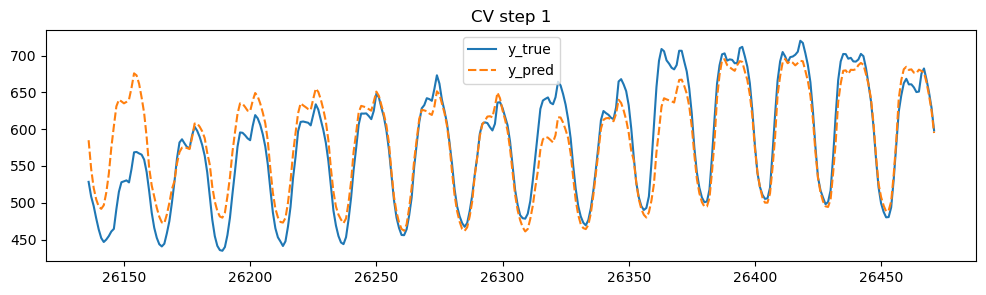

Fold 2:
End of train: 2022-04-01
Test: from 2022-04-02 to 2022-07-01
Lasso MAE: 11.181215951700095
Lasso MAPE: 0.02509847020049561
Lasso r2: 0.9610915060880932


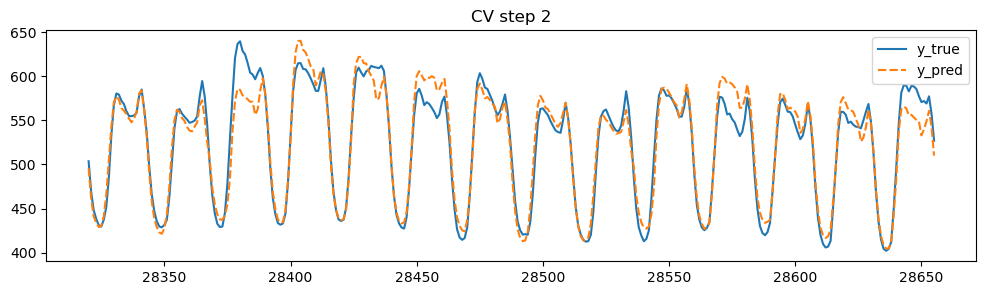

Fold 3:
End of train: 2022-07-01
Test: from 2022-07-02 to 2022-09-30
Lasso MAE: 9.897942138853464
Lasso MAPE: 0.024039580234927787
Lasso r2: 0.9655865816022138


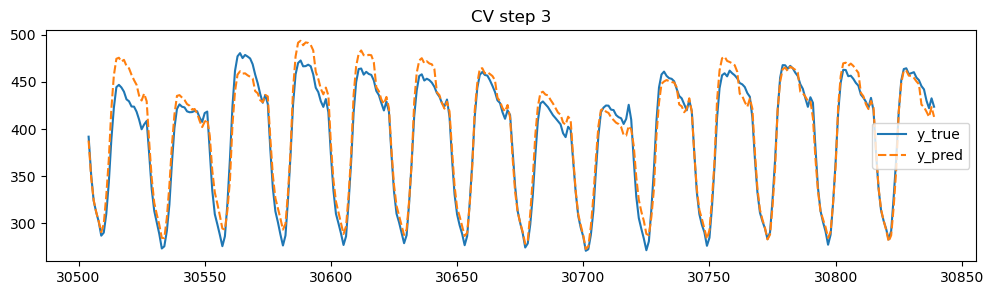

Fold 4:
End of train: 2022-09-30
Test: from 2022-10-01 to 2022-12-30
Lasso MAE: 12.135799894807224
Lasso MAPE: 0.022259776761722094
Lasso r2: 0.9727467200790719


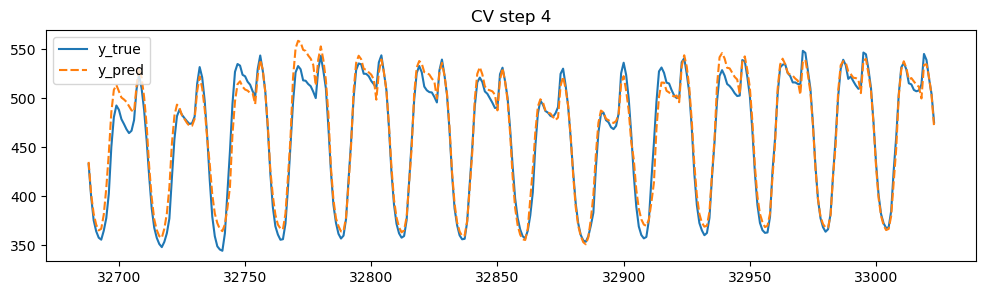

Fold 5:
End of train: 2022-12-30
Test: from 2022-12-31 to 2023-03-31
Lasso MAE: 12.83683804638728
Lasso MAPE: 0.02389048432890953
Lasso r2: 0.9274601605888666


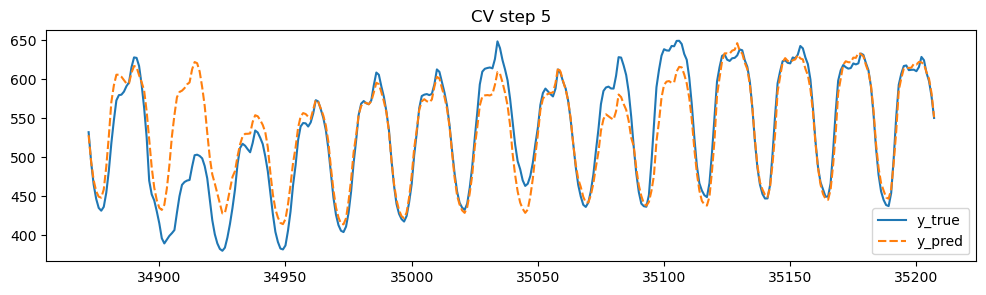

In [12]:
lin_maes, lin_mapes, lin_r2, lin_model = linear_cross_val(df=df, cols_to_take=['target_lag_24', 'target_lag_96', 'target_lag_120', 'target_lag_144', 
                                                                               'target_lag_168', 'temp_pred', 'dow', 'day', 'week', 'jan', 'feb', 'mar', 
                                                                               'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'cos_time', 
                                                                               'working_hour', 'dark_weather', 'yesterday_diff_temp'])

## Оценка модели первого этапа

Посмотрим на средние метрики по итогам кросс-валидации

In [13]:
metrics = {'MAE': lin_maes, 'MAPE': lin_mapes, 'r2': lin_r2}
for metric in metrics:
    print(f"Linreg mean {metric}: {np.mean(metrics[metric])}")

Linreg mean MAE: 11.701999552687964
Linreg mean MAPE: 0.023501716941584375
Linreg mean r2: 0.9534627599249591


И на тесте

In [14]:
test = df[df['date'] >= test_df['date'].min()]
X_test = test[['target_lag_24', 'target_lag_96', 'target_lag_120', 'target_lag_144', 'target_lag_168', 'temp_pred', 'dow', 'day', 'week', 'jan', 'feb', 'mar', 'apr', 'may', 'jun',
       'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'cos_time', 'working_hour', 'dark_weather', 'yesterday_diff_temp']]
y_test = test['target']

preds = lin_model.predict(X_test)
preds = pd.DataFrame({'y_pred': preds, 'date': test['date'], 'y_true': test['target']})   
metrics = evaluate(preds['y_true'], preds['y_pred'], 'Lasso on test')

Lasso on test MAE: 9.974395125079278
Lasso on test MAPE: 0.02399382002693353
Lasso on test r2: 0.9673344927679033


Однако при всех вышеперечисленных преимуществах линейные модели не отличаются высокой точностью

Для сравнения ниже мы рассчитали метрики для константной модели, предсказывающей потребление, равное потреблению ровно сутки назад

In [15]:
metrics = evaluate(test['target'], test['target_lag_24'], 'Constant model')

Constant model MAE: 12.045109631147543
Constant model MAPE: 0.02817953467220212
Constant model r2: 0.9426890365979552


Ошибка линейных моделей велика и относительно стабильна на обучающей и тестовой выборке. Обучим выбранную модель на всей обучающей выборке и сделаем предсказание для всех наблюдений, включая тестовую выборку. Также рассчитаем ошибку модели как разность истинной целевой переменной и предсказаний лассо

In [16]:
train = df[df['date'] < test_df['date'].min()]
X_train = train[['target_lag_24', 'target_lag_96', 'target_lag_120', 'target_lag_144', 'target_lag_168', 'temp_pred', 'dow', 'day', 'week', 'jan', 'feb', 'mar', 'apr', 'may', 'jun',
       'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'cos_time', 'working_hour', 'dark_weather', 'yesterday_diff_temp']]
y_train = train['target']

model_stage1 = make_pipeline(StandardScaler(), Lasso(alpha=0.275))
model_stage1.fit(X_train, y_train)

df['pred_stage1'] = model_stage1.predict(df[['target_lag_24', 'target_lag_96', 'target_lag_120', 'target_lag_144', 'target_lag_168', 'temp_pred', 'dow', 'day', 'week', 'jan', 'feb', 'mar', 'apr', 'may', 'jun',
       'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'cos_time', 'working_hour', 'dark_weather', 'yesterday_diff_temp']])
df['stage1_error'] = df['target'] - df['pred_stage1']


## Второй этап: бустинг на ошибках

На втором этапе постараемся повысить точность нашей модели. Для этого градиентным бустингом предскажем ошибку первой модели и сложим оценки двух моделей для получения финального прогноза. Метрики точности в этом разделе ма рассчитываем не для промежуточных оценок, а для финального прогноза.

In [17]:
def plotImp(model, X, num = 40, fig_size = (15, 5)):
    """
    Функция отрисовывает график важности признаков модели в порядке убывания
    """
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features importance')
    plt.tight_layout()
    plt.show()

In [18]:
def lgbm_cross_val(cols_to_take, cat_features=[], df=df):
    """
    Функция кросс-валидации для LightGBM регрессора
    :param cols_to_take: столбцы, которые модель использует в качестве признаков
    :param cat_features: категориальные признаки. Сейчас их нет, но функция оставляет такую
                         возможность
    :param df: датафрейм, который необходимо разделить на обучающую и тестовую выборки
    """
    maes = []
    mapes = []
    r2 = []

    #separate test from train and valid. it's always the same and corresponds to test_dataset.csv
    crossval_set = df[df['date'] < test_df['date'].min()]

    #use time series split to split train and valid. valid size is about 6 months (3 for valid and 3 for test)
    tscv = TimeSeriesSplit(test_size=91*24)

    for i, (train_index, test_index) in enumerate(tscv.split(crossval_set)):
        print(f"Fold {i+1}:")
        train_and_valid = crossval_set[crossval_set.index.isin(train_index)]
        test = crossval_set[crossval_set.index.isin(test_index)]
        train = train_and_valid.iloc[:-(91*24), :]
        valid = train_and_valid.iloc[-(91*24):, :]      

        end_train = train['date'].max()
        start_valid = valid['date'].min()
        end_valid = valid['date'].max()
        start_test = test['date'].min()
        end_test = test['date'].max()
        test_dates = test['date']

        print(f"End of train: {end_train.date()}")
        print(f"Valid: from {start_valid.date()} to {end_valid.date()}")
        print(f"Test: from {start_test.date()} to {end_test.date()}")

        X_train = train[cols_to_take]
        y_train = train['stage1_error']
        X_valid = valid[cols_to_take]
        y_valid = valid['stage1_error']
        X_test = test[cols_to_take]
        y_test = test['stage1_error'] 
     
        eval_set = [(X_valid, y_valid)]

        cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

        for col in cat_features:
            X_train[col] = pd.Categorical(X_train[col])
            X_valid[col] = pd.Categorical(X_valid[col])
            X_test[col] = pd.Categorical(X_test[col])

        lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, random_state=26, objective='mse')
        lgbm_reg.fit(
                X_train, 
                y_train,        
                categorical_feature=cat_idx,
                eval_set=eval_set,
                early_stopping_rounds=200,
                verbose=100
            )        
           
        #predict for test
        pred_errors = lgbm_reg.predict(X_test)    
        preds = pd.DataFrame({'error_predicted': pred_errors, 'date': test_dates, 'y_true': test['target'], 'stage1_predict': test['pred_stage1']}) 
        preds['y_pred'] = preds['stage1_predict'] + preds['error_predicted']
        
        #evaluete model
        metrics = evaluate(preds['y_true'], preds['y_pred'], 'LGBM')
        maes.append(metrics[0])
        mapes.append(metrics[1])
        r2.append(metrics[2])

        #plot test fact and forecast
        plot_df = pd.DataFrame({'date': preds['date'].head(14*24), 'y_true': preds['y_true'].head(14*24), 'y_pred': preds['y_pred'].head(14*24)})
        fig, ax = plt.subplots(figsize=(12, 3))
        g = sns.lineplot(data=plot_df)
        plt.title(f'CV step {i+1}')
        plt.show()        
                 
        
    plotImp(lgbm_reg, X_train)

    #return model from last fold. it is fit on maximum train dataset
    return(maes, mapes, r2, preds, lgbm_reg)

Fold 1:
End of train: 2021-10-01
Valid: from 2021-10-02 to 2021-12-31
Test: from 2022-01-01 to 2022-04-01
[100]	valid_0's l2: 140.672
[200]	valid_0's l2: 142.218
LGBM MAE: 9.845215681179814
LGBM MAPE: 0.017183652744463263
LGBM r2: 0.9690753579616653


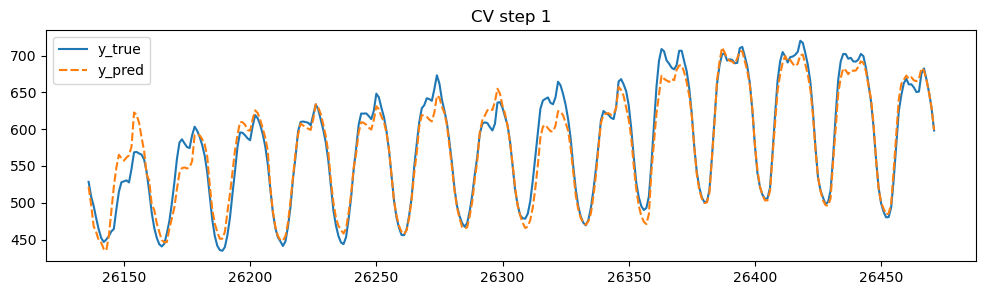

Fold 2:
End of train: 2021-12-31
Valid: from 2022-01-01 to 2022-04-01
Test: from 2022-04-02 to 2022-07-01
[100]	valid_0's l2: 173.131
[200]	valid_0's l2: 172.741
[300]	valid_0's l2: 169.809
[400]	valid_0's l2: 168.232
[500]	valid_0's l2: 169.355
LGBM MAE: 8.636304941926474
LGBM MAPE: 0.019031943568716615
LGBM r2: 0.9735969494270246


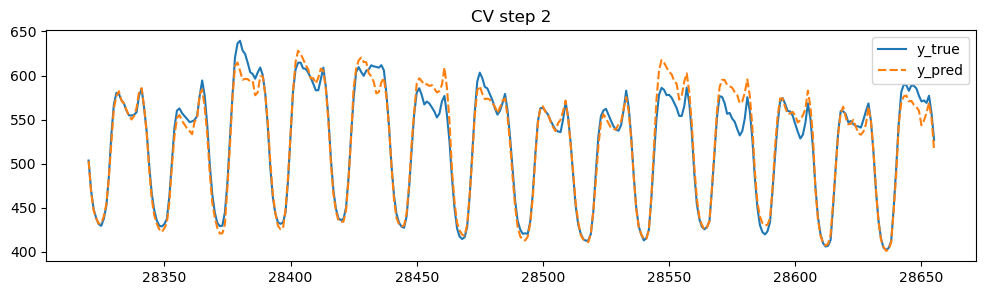

Fold 3:
End of train: 2022-04-01
Valid: from 2022-04-02 to 2022-07-01
Test: from 2022-07-02 to 2022-09-30
[100]	valid_0's l2: 148.316
[200]	valid_0's l2: 142.628
[300]	valid_0's l2: 141.459
[400]	valid_0's l2: 140.19
[500]	valid_0's l2: 139.992
[600]	valid_0's l2: 140.374
[700]	valid_0's l2: 140.452
LGBM MAE: 6.1639230225678405
LGBM MAPE: 0.014686550725857344
LGBM r2: 0.9848067097083415


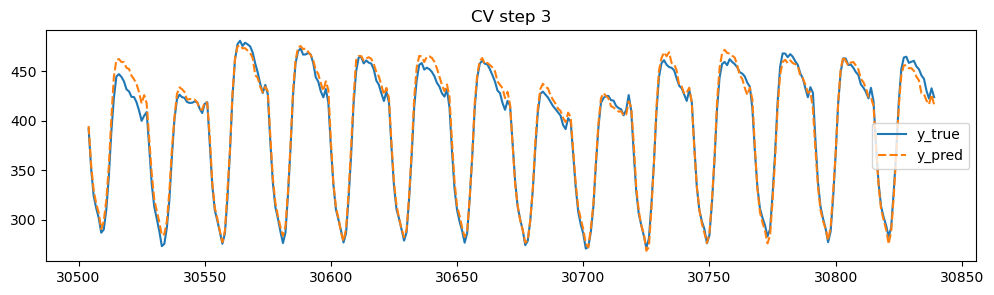

Fold 4:
End of train: 2022-07-01
Valid: from 2022-07-02 to 2022-09-30
Test: from 2022-10-01 to 2022-12-30
[100]	valid_0's l2: 74.5472
[200]	valid_0's l2: 71.481
[300]	valid_0's l2: 70.1761
[400]	valid_0's l2: 69.3753
[500]	valid_0's l2: 69.5933
[600]	valid_0's l2: 69.962
LGBM MAE: 7.910790584457013
LGBM MAPE: 0.014515512971524877
LGBM r2: 0.9880418847394934


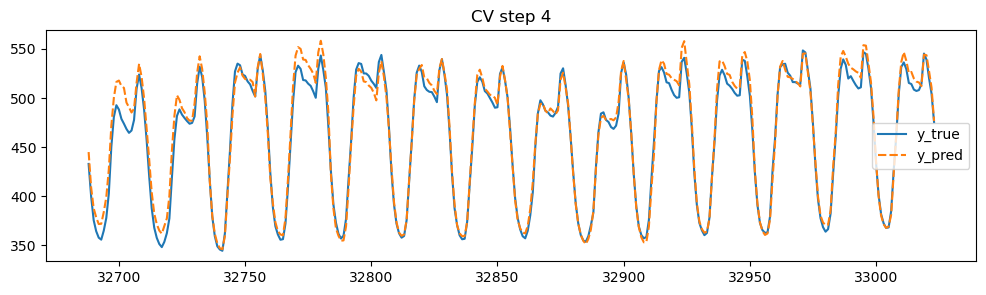

Fold 5:
End of train: 2022-09-30
Valid: from 2022-10-01 to 2022-12-30
Test: from 2022-12-31 to 2023-03-31
[100]	valid_0's l2: 99.509
[200]	valid_0's l2: 96.5964
[300]	valid_0's l2: 96.413
[400]	valid_0's l2: 96.0727
[500]	valid_0's l2: 95.625
[600]	valid_0's l2: 95.815
LGBM MAE: 8.670260635396167
LGBM MAPE: 0.01579141267693568
LGBM r2: 0.9699599239288439


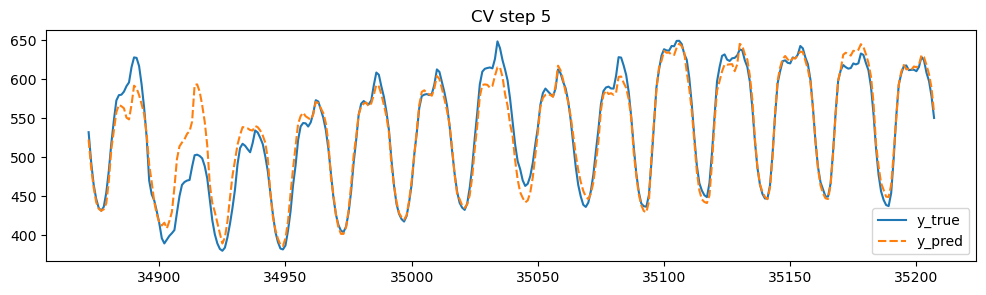

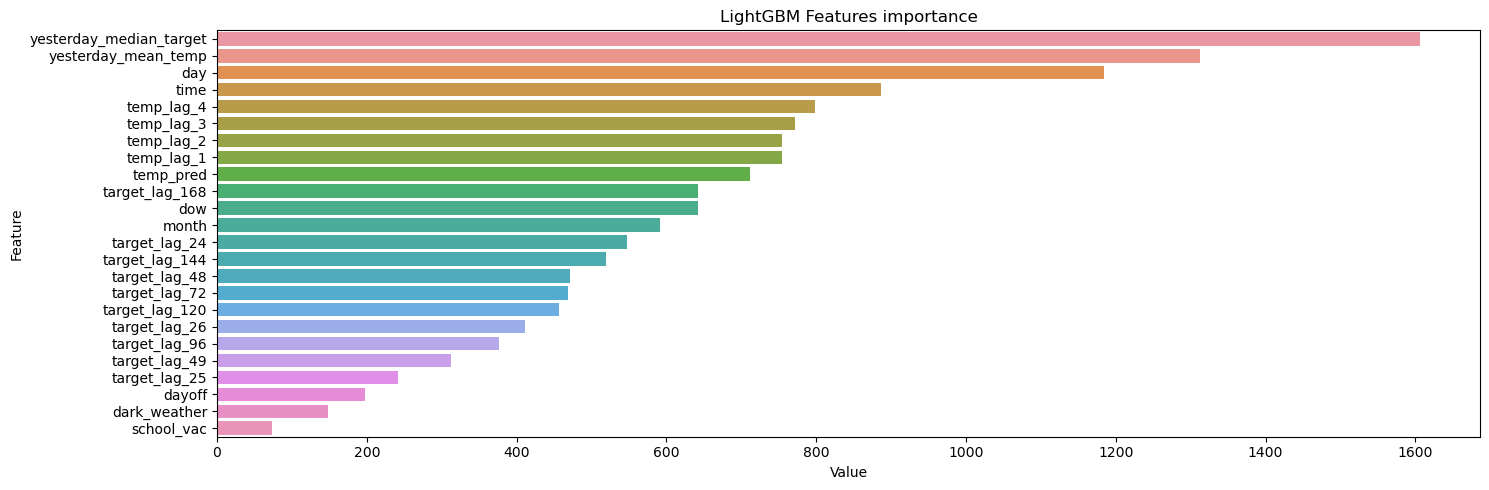

In [19]:
lgbm_maes, lgbm_mapes, lgbm_r2, lgbm_forecast, lgbm_model = lgbm_cross_val(df=df, cols_to_take=['target_lag_24', 'target_lag_48', 'target_lag_72', 'target_lag_96', 'target_lag_120', 'target_lag_144', 'target_lag_168', 'target_lag_25',
               'target_lag_26', 'target_lag_49', 'temp_pred', 'dow', 'day', 'month', 'time', 'yesterday_median_target', 'yesterday_mean_temp',
               'dayoff', 'dark_weather', 'temp_lag_1', 'temp_lag_2', 'temp_lag_3', 'temp_lag_4', 'school_vac'])

## Оценка модели второго этапа

На кросс-валидации:

In [20]:
metrics = {'MAE': lgbm_maes, 'MAPE': lgbm_mapes, 'r2': lgbm_r2}
for metric in metrics:
    print(f"LGBM mean {metric}: {np.mean(metrics[metric])}")

LGBM mean MAE: 8.245298973105461
LGBM mean MAPE: 0.016241814537499556
LGBM mean r2: 0.9770961651530736


И на тесте:

In [21]:
test = df[df['date'] >= test_df['date'].min()]
X_test = test[['target_lag_24', 'target_lag_48', 'target_lag_72', 'target_lag_96', 'target_lag_120', 'target_lag_144', 'target_lag_168', 'target_lag_25',
               'target_lag_26', 'target_lag_49', 'temp_pred', 'dow', 'day', 'month', 'time', 'yesterday_median_target', 'yesterday_mean_temp',
               'dayoff', 'dark_weather', 'temp_lag_1', 'temp_lag_2', 'temp_lag_3', 'temp_lag_4', 'school_vac']]

pred_errors = lgbm_model.predict(X_test)    
preds = pd.DataFrame({'error_predicted': pred_errors, 'date': test['date'], 'y_true': test['target'], 'stage1_predict': test['pred_stage1']}) 
preds['y_pred'] = preds['stage1_predict'] + preds['error_predicted']
metrics = evaluate(preds['y_true'], preds['y_pred'], 'LGBM on train')

LGBM on train MAE: 7.046905527847646
LGBM on train MAPE: 0.01638676139338267
LGBM on train r2: 0.9802694227102784


Используем Optuna для тюнинга гиперпараметров. Это позволит еще немного повысить точность

In [22]:
def objective(trial, df=df, cols_to_take=['target_lag_24', 'target_lag_48', 'target_lag_72', 'target_lag_96', 'target_lag_120', 'target_lag_144', 'target_lag_168', 'target_lag_25',
               'target_lag_26', 'target_lag_49', 'temp_pred', 'dow', 'day', 'month', 'time', 'yesterday_median_target', 'yesterday_mean_temp',
               'dayoff', 'dark_weather', 'temp_lag_1', 'temp_lag_2', 'temp_lag_3', 'temp_lag_4', 'school_vac'], cat_features=[], h=3):
    
    crossval_set = df[df['date'] < test_df['date'].min()]
        
    train = crossval_set.iloc[:-(91*24), :]
    valid = crossval_set.iloc[-(91*24):, :]

    X_train = train[cols_to_take]
    y_train = train['stage1_error']
    X_valid = valid[cols_to_take]
    y_valid = valid['stage1_error']

    eval_set = [(X_valid, y_valid)]

    cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

    for col in cat_features:
        X_train[col] = pd.Categorical(X_train[col])
        X_valid[col] = pd.Categorical(X_valid[col])

    param = {
        'metric': 'mse', 
        'random_state': 26,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1)
    }
    model = lgbm.LGBMRegressor(**param)  
    
    model.fit(X_train,y_train,categorical_feature=cat_idx,eval_set=eval_set,early_stopping_rounds=100,verbose=500)
    
    preds = model.predict(X_valid)

    trial.set_user_attr(key="best_booster", value=model)
    
    return mean_absolute_error(y_valid, preds)

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction='minimize'
    )
    study.optimize(objective, n_trials=10, callbacks=[callback])
    best_model=study.user_attrs["best_booster"]

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-11-04 22:50:08,771] A new study created in memory with name: no-name-4130c0bc-c972-40bf-8895-1561c1630b39


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l2: 174.981
[1000]	valid_0's l2: 164.185


[I 2023-11-04 22:50:52,221] Trial 0 finished with value: 8.653643444155929 and parameters: {'reg_alpha': 0.22040070588473215, 'reg_lambda': 0.064125401136413, 'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 413, 'min_child_samples': 88, 'feature_fraction': 0.9}. Best is trial 0 with value: 8.653643444155929.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.4
[500]	valid_0's l2: 217.925
[1000]	valid_0's l2: 190.482
[1500]	valid_0's l2: 179.847
[2000]	valid_0's l2: 174.889
[2500]	valid_0's l2: 172.193
[3000]	valid_0's l2: 169.911
[3500]	valid_0's l2: 168.933
[4000]	valid_0's l2: 167.977
[4500]	valid_0's l2: 167.371
[5000]	valid_0's l2: 166.9


[I 2023-11-04 22:53:29,922] Trial 1 finished with value: 8.807453025419568 and parameters: {'reg_alpha': 2.7412915735093915, 'reg_lambda': 9.725627776976026, 'colsample_bytree': 0.9, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 895, 'min_child_samples': 231, 'feature_fraction': 0.4}. Best is trial 0 with value: 8.653643444155929.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[500]	valid_0's l2: 177.475
[1000]	valid_0's l2: 163.721
[1500]	valid_0's l2: 158.513


[I 2023-11-04 22:54:09,006] Trial 2 finished with value: 8.615464706374711 and parameters: {'reg_alpha': 1.6463138438928802, 'reg_lambda': 0.00174255741599405, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 427, 'min_child_samples': 196, 'feature_fraction': 0.8}. Best is trial 2 with value: 8.615464706374711.


[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.2
[500]	valid_0's l2: 224.797
[1000]	valid_0's l2: 205.47
[1500]	valid_0's l2: 200.56
[2000]	valid_0's l2: 198.537
[2500]	valid_0's l2: 197.737
[3000]	valid_0's l2: 197.289
[3500]	valid_0's l2: 196.924
[4000]	valid_0's l2: 196.691
[4500]	valid_0's l2: 196.472
[5000]	valid_0's l2: 196.337


[I 2023-11-04 22:59:50,761] Trial 3 finished with value: 9.516397224477412 and parameters: {'reg_alpha': 0.1563124604524614, 'reg_lambda': 0.12559581047267185, 'colsample_bytree': 0.6, 'subsample': 0.7, 'learning_rate': 0.014, 'max_depth': 100, 'num_leaves': 444, 'min_child_samples': 56, 'feature_fraction': 0.2}. Best is trial 2 with value: 8.615464706374711.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.30000000000000004
[500]	valid_0's l2: 220.919
[1000]	valid_0's l2: 214.964
[1500]	valid_0's l2: 213.694
[2000]	valid_0's l2: 213.176


[I 2023-11-04 23:02:34,379] Trial 4 finished with value: 9.60298383429225 and parameters: {'reg_alpha': 0.007005758640505869, 'reg_lambda': 0.006263143005449042, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 20, 'num_leaves': 690, 'min_child_samples': 18, 'feature_fraction': 0.30000000000000004}. Best is trial 2 with value: 8.615464706374711.


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.5
[500]	valid_0's l2: 181.689
[1000]	valid_0's l2: 171.768
[1500]	valid_0's l2: 169.651
[2000]	valid_0's l2: 168.871
[2500]	valid_0's l2: 168.382


[I 2023-11-04 23:04:40,365] Trial 5 finished with value: 8.880674456302545 and parameters: {'reg_alpha': 0.412042835491753, 'reg_lambda': 0.12525235462160147, 'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 861, 'min_child_samples': 135, 'feature_fraction': 0.5}. Best is trial 2 with value: 8.615464706374711.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.7
[500]	valid_0's l2: 214.219
[1000]	valid_0's l2: 187.647
[1500]	valid_0's l2: 177.672
[2000]	valid_0's l2: 171.754
[2500]	valid_0's l2: 167.432
[3000]	valid_0's l2: 163.958
[3500]	valid_0's l2: 162.308


[I 2023-11-04 23:06:16,478] Trial 6 finished with value: 8.700092333725305 and parameters: {'reg_alpha': 0.010592695454561782, 'reg_lambda': 0.0012615053485906602, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 10, 'num_leaves': 916, 'min_child_samples': 284, 'feature_fraction': 0.7}. Best is trial 2 with value: 8.615464706374711.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.6 will be ignored. Current value: feature_fraction=0.4
[500]	valid_0's l2: 194.186
[1000]	valid_0's l2: 178.121
[1500]	valid_0's l2: 171.989
[2000]	valid_0's l2: 169.56
[2500]	valid_0's l2: 168.186


[I 2023-11-04 23:07:37,632] Trial 7 finished with value: 8.829419108857266 and parameters: {'reg_alpha': 0.07063174495226501, 'reg_lambda': 4.500346505537112, 'colsample_bytree': 0.6, 'subsample': 0.6, 'learning_rate': 0.017, 'max_depth': 20, 'num_leaves': 809, 'min_child_samples': 235, 'feature_fraction': 0.4}. Best is trial 2 with value: 8.615464706374711.


[LightGBM] [Warning] feature_fraction is set=0.30000000000000004, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.30000000000000004
[500]	valid_0's l2: 241.709
[1000]	valid_0's l2: 203.263
[1500]	valid_0's l2: 189.55
[2000]	valid_0's l2: 182.975
[2500]	valid_0's l2: 178.085
[3000]	valid_0's l2: 174.751
[3500]	valid_0's l2: 172.271
[4000]	valid_0's l2: 170.352
[4500]	valid_0's l2: 169.14
[5000]	valid_0's l2: 168.099
[5500]	valid_0's l2: 167.197


[I 2023-11-04 23:09:08,666] Trial 8 finished with value: 8.828390935219636 and parameters: {'reg_alpha': 0.03660186739936817, 'reg_lambda': 0.07008888397732088, 'colsample_bytree': 0.7, 'subsample': 0.4, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 31, 'min_child_samples': 167, 'feature_fraction': 0.30000000000000004}. Best is trial 2 with value: 8.615464706374711.


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.4
[500]	valid_0's l2: 209.633
[1000]	valid_0's l2: 182.686
[1500]	valid_0's l2: 174.327
[2000]	valid_0's l2: 171.105
[2500]	valid_0's l2: 169.492
[3000]	valid_0's l2: 168.479
[3500]	valid_0's l2: 167.745


[I 2023-11-04 23:11:00,177] Trial 9 finished with value: 8.823247057564792 and parameters: {'reg_alpha': 0.27639683272221804, 'reg_lambda': 0.15520843984737284, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.01, 'max_depth': 20, 'num_leaves': 395, 'min_child_samples': 176, 'feature_fraction': 0.4}. Best is trial 2 with value: 8.615464706374711.


Number of finished trials: 10
Best trial: {'reg_alpha': 1.6463138438928802, 'reg_lambda': 0.00174255741599405, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 427, 'min_child_samples': 196, 'feature_fraction': 0.8}


In [27]:
study.optimize(objective, n_trials=10, callbacks=[callback])
best_model=study.user_attrs["best_booster"]

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[500]	valid_0's l2: 220.364
[1000]	valid_0's l2: 190.198
[1500]	valid_0's l2: 179.35
[2000]	valid_0's l2: 173.178
[2500]	valid_0's l2: 169.271
[3000]	valid_0's l2: 166.844
[3500]	valid_0's l2: 165.273
[4000]	valid_0's l2: 164.404
[4500]	valid_0's l2: 163.343
[5000]	valid_0's l2: 162.634


[I 2023-11-04 23:14:55,766] Trial 10 finished with value: 8.654753182741763 and parameters: {'reg_alpha': 9.058097299851829, 'reg_lambda': 0.0015257515637379158, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.008, 'max_depth': 10, 'num_leaves': 127, 'min_child_samples': 234, 'feature_fraction': 0.8}. Best is trial 2 with value: 8.615464706374711.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.8 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l2: 222.192
[1000]	valid_0's l2: 190.244
[1500]	valid_0's l2: 178.416
[2000]	valid_0's l2: 172.851
[2500]	valid_0's l2: 169.803
[3000]	valid_0's l2: 167.042
[3500]	valid_0's l2: 165.417


[I 2023-11-04 23:16:24,484] Trial 11 finished with value: 8.701479556711266 and parameters: {'reg_alpha': 0.911030424618026, 'reg_lambda': 0.01228955613328459, 'colsample_bytree': 0.8, 'subsample': 0.4, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 271, 'min_child_samples': 111, 'feature_fraction': 0.9}. Best is trial 2 with value: 8.615464706374711.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[500]	valid_0's l2: 169.831
[1000]	valid_0's l2: 161.729


[I 2023-11-04 23:16:55,932] Trial 12 finished with value: 8.690463380857429 and parameters: {'reg_alpha': 1.1521607254532493, 'reg_lambda': 0.011389577901915733, 'colsample_bytree': 1.0, 'subsample': 0.4, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 611, 'min_child_samples': 72, 'feature_fraction': 0.7}. Best is trial 2 with value: 8.615464706374711.


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=0.3 will be ignored. Current value: feature_fraction=0.9
[500]	valid_0's l2: 174.721
[1000]	valid_0's l2: 165.126
[1500]	valid_0's l2: 162.681


[I 2023-11-04 23:17:46,597] Trial 13 finished with value: 8.71513666427808 and parameters: {'reg_alpha': 2.9855074807298667, 'reg_lambda': 0.745531660370042, 'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 298, 'min_child_samples': 94, 'feature_fraction': 0.9}. Best is trial 2 with value: 8.615464706374711.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.7
[500]	valid_0's l2: 180.315
[1000]	valid_0's l2: 165.951
[1500]	valid_0's l2: 159.696
[2000]	valid_0's l2: 157.502


[I 2023-11-04 23:18:19,023] Trial 14 finished with value: 8.604418057361652 and parameters: {'reg_alpha': 0.0020236217169253066, 'reg_lambda': 0.03480336262623035, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 592, 'min_child_samples': 198, 'feature_fraction': 0.7}. Best is trial 14 with value: 8.604418057361652.


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.7
[500]	valid_0's l2: 178.802
[1000]	valid_0's l2: 165.947
[1500]	valid_0's l2: 160.572


[I 2023-11-04 23:18:56,468] Trial 15 finished with value: 8.640169737018898 and parameters: {'reg_alpha': 0.0011266391075475514, 'reg_lambda': 0.0037147943835650677, 'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 610, 'min_child_samples': 196, 'feature_fraction': 0.7}. Best is trial 14 with value: 8.604418057361652.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6000000000000001
[500]	valid_0's l2: 246.314
[1000]	valid_0's l2: 206.575
[1500]	valid_0's l2: 191.583
[2000]	valid_0's l2: 184.019
[2500]	valid_0's l2: 178.726
[3000]	valid_0's l2: 174.626
[3500]	valid_0's l2: 171.857
[4000]	valid_0's l2: 169.405
[4500]	valid_0's l2: 167.851
[5000]	valid_0's l2: 166.552
[5500]	valid_0's l2: 165.39
[6000]	valid_0's l2: 164.522


[I 2023-11-04 23:21:01,064] Trial 16 finished with value: 8.73352050982113 and parameters: {'reg_alpha': 0.0013035526988958144, 'reg_lambda': 0.027372282363584598, 'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.006, 'max_depth': 10, 'num_leaves': 557, 'min_child_samples': 293, 'feature_fraction': 0.6000000000000001}. Best is trial 14 with value: 8.604418057361652.


[LightGBM] [Warning] feature_fraction is set=0.6000000000000001, colsample_bytree=0.4 will be ignored. Current value: feature_fraction=0.6000000000000001
[500]	valid_0's l2: 216.718
[1000]	valid_0's l2: 186.434
[1500]	valid_0's l2: 176.519
[2000]	valid_0's l2: 171.822
[2500]	valid_0's l2: 169.92
[3000]	valid_0's l2: 168.309
[3500]	valid_0's l2: 167.189
[4000]	valid_0's l2: 166.625
[4500]	valid_0's l2: 166.313


[I 2023-11-04 23:23:46,933] Trial 17 finished with value: 8.842401309805417 and parameters: {'reg_alpha': 0.04257327165307576, 'reg_lambda': 0.002961903869978074, 'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.008, 'max_depth': 100, 'num_leaves': 686, 'min_child_samples': 198, 'feature_fraction': 0.6000000000000001}. Best is trial 14 with value: 8.604418057361652.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.8
[500]	valid_0's l2: 171.224
[1000]	valid_0's l2: 158.919


[I 2023-11-04 23:24:12,028] Trial 18 finished with value: 8.606540449870897 and parameters: {'reg_alpha': 0.009869003602216523, 'reg_lambda': 0.018829389082479296, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.02, 'max_depth': 10, 'num_leaves': 264, 'min_child_samples': 144, 'feature_fraction': 0.8}. Best is trial 14 with value: 8.604418057361652.


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.8
[500]	valid_0's l2: 176.096
[1000]	valid_0's l2: 160.86
[1500]	valid_0's l2: 157.858


[I 2023-11-04 23:24:40,028] Trial 19 finished with value: 8.558255640250739 and parameters: {'reg_alpha': 0.0032298318822767237, 'reg_lambda': 0.021302221878087415, 'colsample_bytree': 0.7, 'subsample': 0.5, 'learning_rate': 0.017, 'max_depth': 10, 'num_leaves': 237, 'min_child_samples': 139, 'feature_fraction': 0.8}. Best is trial 19 with value: 8.558255640250739.


Оценим результат на тесте:

In [29]:
X_test = test[['target_lag_24', 'target_lag_48', 'target_lag_72', 'target_lag_96', 'target_lag_120', 'target_lag_144', 'target_lag_168', 'target_lag_25',
               'target_lag_26', 'target_lag_49', 'temp_pred', 'dow', 'day', 'month', 'time', 'yesterday_median_target', 'yesterday_mean_temp',
               'dayoff', 'dark_weather', 'temp_lag_1', 'temp_lag_2', 'temp_lag_3', 'temp_lag_4', 'school_vac']]

pred_errors = best_model.predict(X_test)    
preds = pd.DataFrame({'error_predicted': pred_errors, 'date': test['date'], 'y_true': test['target'], 'stage1_predict': test['pred_stage1']}) 
preds['y_pred'] = preds['stage1_predict'] + preds['error_predicted']
metrics = evaluate(preds['y_true'], preds['y_pred'], 'LGBM after Optuna')

LGBM after Optuna MAE: 6.941922268088516
LGBM after Optuna MAPE: 0.016155643506741615
LGBM after Optuna r2: 0.9813668334440425


## Сохранение моделей

Сохраним модель для дальнейшего использования

In [30]:
# save the models to pickle files
lin_pkl = "model1.pkl"
lgbm_pkl = "model2.pkl"  

with open(lin_pkl, 'wb') as file:  
    pickle.dump(lin_model, file)

with open(lgbm_pkl, 'wb') as file:  
    pickle.dump(best_model, file)

Убедимся, что качество модели, загруженной из файла, не отличается

In [31]:
# load models from pickle files
with open(lin_pkl, 'rb') as file:  
    lin_reg_loaded = pickle.load(file)
with open(lgbm_pkl, 'rb') as file:  
    lgbm_reg_loaded = pickle.load(file)

In [32]:
df['pred_stage1'] = lin_reg_loaded.predict(df[['target_lag_24', 'target_lag_96', 'target_lag_120', 'target_lag_144', 'target_lag_168', 'temp_pred', 'dow', 
                                               'day', 'week', 'jan', 'feb', 'mar', 'apr', 'may', 'jun',
       'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'cos_time', 'working_hour', 'dark_weather', 'yesterday_diff_temp']])
df['stage1_error'] = df['target'] - df['pred_stage1']

X_test = test[['target_lag_24', 'target_lag_48', 'target_lag_72', 'target_lag_96', 'target_lag_120', 'target_lag_144', 'target_lag_168', 'target_lag_25',
               'target_lag_26', 'target_lag_49', 'temp_pred', 'dow', 'day', 'month', 'time', 'yesterday_median_target', 'yesterday_mean_temp',
               'dayoff', 'dark_weather', 'temp_lag_1', 'temp_lag_2', 'temp_lag_3', 'temp_lag_4', 'school_vac']]

pred_errors = lgbm_reg_loaded.predict(X_test)    
preds = pd.DataFrame({'error_predicted': pred_errors, 'date': test['date'], 'y_true': test['target'], 'stage1_predict': test['pred_stage1']}) 
preds['y_pred'] = preds['stage1_predict'] + preds['error_predicted']
metrics = evaluate(preds['y_true'], preds['y_pred'], 'Saved models')

Saved models MAE: 6.941922268088516
Saved models MAPE: 0.016155643506741615
Saved models r2: 0.9813668334440425


Метрики на обучающей выборке:

In [56]:
train = df[df['date'] < test_df['date'].min()]
X_train = train[['target_lag_24', 'target_lag_48', 'target_lag_72', 'target_lag_96', 'target_lag_120', 'target_lag_144', 'target_lag_168', 'target_lag_25',
               'target_lag_26', 'target_lag_49', 'temp_pred', 'dow', 'day', 'month', 'time', 'yesterday_median_target', 'yesterday_mean_temp',
               'dayoff', 'dark_weather', 'temp_lag_1', 'temp_lag_2', 'temp_lag_3', 'temp_lag_4', 'school_vac']]

pred_errors = lgbm_reg_loaded.predict(X_train)
preds = pd.DataFrame({'error_predicted': pred_errors, 'date': train['date'], 'y_true': train['target'], 'stage1_predict': train['pred_stage1']}) 
preds['y_pred'] = preds['stage1_predict'] + preds['error_predicted']
metrics = evaluate(preds['y_true'], preds['y_pred'], 'Model on train')

Model on train MAE: 3.266476836631244
Model on train MAPE: 0.006829187313311116
Model on train r2: 0.9975653352268004


Все верно, результат совпадает с финальным после оптимизации гиперпараметров